<a href="https://colab.research.google.com/github/SayantikaFSU/Projects/blob/main/TitanicDataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I have used the same titanic dataset, however applied the Classification ML model approach
******************************************************************

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T043256Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4155dbb28628673f18b89a0c486ac6cabe58d237a56ca63b95a519dfe5ae3836382c2deac90e12df9b1a7e026941b314ba9daddbaba36893f489c98de42df3ec3ac257117366c5366db46c2e35ebe8b53b6610e85145bc26958641306f4b0093bd06dc28cbcc3fce7722bcb7416383a3d53ccd498045c297e3cb8fc33ccc95cee2fe9070864db34e0f899b1439a7836e0180044ad971ba83f3dfb8d80beb96800c3f3811834bdbb31ea6fe370334bfb3387355b382565fffb7ec1751bf5640a71ad55a39cefd5a224c8163ec8599464cf859de9af21f2750609cff623c006f2851ddc111cd4b83da51dfc5d777ba789dc707f31924012b291a59961874295654'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


This notebook deals with the Titanic Data Set available in the Kaggle platform.
Goal : to predict the Survival of each passenger. The result consists of the passegenID and Survival in each case of the "test.csv".
If passenger Survived =1  or Not Survived =0
**********************************************************************************

In [3]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
import re
import warnings

In [4]:
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")


test= pd.read_csv('/kaggle/input/titanic/test.csv')
train= pd.read_csv('/kaggle/input/titanic/train.csv')
#print(train.head(2),test.head(2))
print(train.shape)
#print(train.columns)
#print(train.head(5))
print(train.info())


print(test.info())

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64 

In [5]:
# columns with nan values: Train Set:

# Set the threshold for missing values:
threshold = 0
# Calculate the percentage of missing values for each column
missing_percentage = train.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_percentage[missing_percentage > threshold].index

# Print the column names
print(f"{len(columns_with_high_missing_values)} Columns have {threshold*100}% or more missing values, Column names-- \n",columns_with_high_missing_values)


3 Columns have 0% or more missing values, Column names-- 
 Index(['Age', 'Cabin', 'Embarked'], dtype='object')


In [6]:
# columns with nan values: Test Set:

# Set the threshold for missing values:
threshold = 0
# Calculate the percentage of missing values for each column
missing_percentage = test.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_percentage[missing_percentage > threshold].index

# Print the column names
print(f"{len(columns_with_high_missing_values)} Columns have {threshold*100}% or more missing values, Column names-- \n",columns_with_high_missing_values)


3 Columns have 0% or more missing values, Column names-- 
 Index(['Age', 'Fare', 'Cabin'], dtype='object')


In [7]:
# Find the row numbers with NAN values in a particular column : Train Set

column_name = 'Embarked'

# Create a boolean mask for NaN values in the specified column
nan_mask = train[column_name].isna()

# Use the boolean mask to get the row numbers with NaN values
rows_with_nan = train[nan_mask].index.tolist()

# Print the row numbers
print("Rows with NaN values in '{}' column: {}".format(column_name, rows_with_nan))
print(len(rows_with_nan))

Rows with NaN values in 'Embarked' column: [61, 829]
2


In [8]:
# Find the row numbers with NAN values in a particular column : Test Set

column_name = 'Cabin'

# Create a boolean mask for NaN values in the specified column
nan_mask = test[column_name].isna()

# Use the boolean mask to get the row numbers with NaN values
rows_with_nan = test[nan_mask].index.tolist()

# Print the row numbers
#print("Rows with NaN values in '{}' column: {}".format(column_name, rows_with_nan))
#print(len(rows_with_nan))


#fill nan with 0:



test['Age'] = test['Age'].fillna(0)
test['Fare']=test['Fare'].fillna(0)
test['Cabin']=test['Cabin'].fillna(0)

In [9]:
# Drop rows with NaN values in the specified column
train_cleaned = train.dropna(subset=['Embarked'])

# Print the cleaned DataFrame
print("DataFrame after dropping rows with NaN values in '{}' column:".format(column_name))
print(train_cleaned.shape)

DataFrame after dropping rows with NaN values in 'Cabin' column:
(889, 12)


For the rest of the notebook :

data=train_cleaned

data_test=test

In [10]:
data=train_cleaned
data.shape

(889, 12)

In [11]:
data_test=test
test.shape

(418, 11)

Section : FEATURE ENGGENEERING
********************************************************************

In [12]:
# (A) convert Sex to numeric:

data['Sex'] = data['Sex'].map({'male': 1, 'female': 0})
print(data.shape)

data_test['Sex'] = data_test['Sex'].map({'male': 1, 'female': 0})
print(data_test.shape)

(889, 12)
(418, 11)


In [13]:
#(B)set embarked to S if not stated then set to numeric
data['Embarked'] = data['Embarked'].fillna('S')
data['Embarked'] = data['Embarked'].map({'Q': 2, 'S': 1, 'C': 0})

print(data.shape)



data_test['Embarked'] = data_test['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].map({'Q': 2, 'S': 1, 'C': 0})

print(data_test.shape)

(889, 12)
(418, 11)


In [14]:
#(C)add feature that tells whether a passenger had a cabin on the Titanic

data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#print(data)


data_test['Has_Cabin'] = data_test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1


In [15]:
# (D)Create new feature FamilySize as a combination of SibSp and Parch
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1
data

data_test['Family_Size'] = data_test['SibSp'] + data_test['Parch'] + 1
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1,1


In [16]:
# (E)Create new feature IsAlone from FamilySize
data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1
data


data_test['IsAlone'] = 0
data_test.loc[data_test['Family_Size'] == 1, 'IsAlone'] = 1
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1,1,1


In [17]:
#find quantiles of the column 'Fare'


column_name = 'Fare'

# Specify the quantiles you want to calculate (e.g., 25%, 50%, 75%)
quantiles = [0.25, 0.5, 0.75]

# Use the quantile function to calculate quantiles for the specified column
column_quantiles = data[column_name].quantile(quantiles)

# Print the quantiles
print("Quantiles for '{}' column:".format(column_name))
print(column_quantiles)


Quantiles for 'Fare' column:
0.25     7.8958
0.50    14.4542
0.75    31.0000
Name: Fare, dtype: float64


In [18]:
#(F) Fare Bins pushed into 4 quantiles

data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[ data['Fare'] > 31, 'Fare']  = 3
data['Fare'] = data['Fare'].astype(int)

data






data_test.loc[ data_test['Fare'] <= 7.91, 'Fare'] = 0
data_test.loc[(data_test['Fare'] > 7.91) & (data_test['Fare'] <= 14.454), 'Fare'] = 1
data_test.loc[(data_test['Fare'] > 14.454) & (data_test['Fare'] <= 31), 'Fare']   = 2
data_test.loc[ data_test['Fare'] > 31, 'Fare']  = 3
data_test['Fare'] = data_test['Fare'].astype(int)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,0,0,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,0,0,1,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,1,0,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,1,0,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,1,0,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,1,0,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,3,C105,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,0,0,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,1,0,1,1,1,1


In [19]:
# (G):Create a new feature Title, containing the titles of passenger names. Replace rare titles with "rare"
#replace and fix miss spellings
#map str to intergrers and fill none with 0


def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return

get_title(data['Name'][0])


'Mr'

In [20]:
data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
data['Title'] = data['Title'].fillna(0)

data





data_test['Title'] = data_test['Name'].apply(get_title)
data_test['Title'] = data_test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data_test['Title'] = data_test['Title'].replace('Mlle', 'Miss')
data_test['Title'] = data_test['Title'].replace('Ms', 'Miss')
data_test['Title'] = data_test['Title'].replace('Mme', 'Mrs')
data_test['Title'] = data_test['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
data_test['Title'] = data_test['Title'].fillna(0)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,0,0,2,1,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,0,0,1,1,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,1,0,2,1,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,1,0,1,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,1,0,1,1,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,1,0,1,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,3,C105,0,1,1,1,5
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,0,0,1,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,1,0,1,1,1,1,1


In [21]:
column_name = 'Age'

# Replace NaN values with 0 in 'Age'
data[column_name] = data[column_name].fillna(0)

# Print the DataFrame after the replacement
#print("DataFrame after replacing NaN values with 0 in '{}' column:".format(column_name))
#print(data)
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin',
       'Family_Size', 'IsAlone', 'Title'],
      dtype='object')

Section : DATA MODELS

We are treating it here as a classification problem where output consists of two classes

survived =1, Not Survived =0

******************************************************************************************

In [22]:
predictor_columns=[ 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin',
       'IsAlone', 'Title']
response_column=['Survived']

X=data[predictor_columns]
Y=data[response_column]

X.shape, Y.shape

((889, 8), (889, 1))

Model 1: Logistic Regression For Binary Classification
****************************************************************

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
mse_logit=mean_squared_error(y_val,y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for logistic classifier {mse_logit:0.3f}")


Accuracy: 0.7921348314606742
Confusion Matrix:
 [[86 23]
 [14 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       109
           1       0.71      0.80      0.75        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.79       178
weighted avg       0.80      0.79      0.79       178

MSE for logistic classifier 0.208


Logistic Regression for binary Classification with recursive feature selection
***********************************************************************************************

In [24]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



# Create the Logistic Regression model
logreg_model = LogisticRegression()


# Create the RFECV model with cross-validation
rfecv = RFECV(estimator=logreg_model, step=1, cv=5, scoring='accuracy')


# Fit the RFECV model to the training data
rfecv.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfecv.n_features_

# Print the selected features
selected_features= pd.DataFrame({'Feature': X.columns, 'Selected': rfecv.support_, 'Ranking': rfecv.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the training and testing sets to keep only the selected features
X_train_selected = rfecv.transform(X_train)
X_val_selected = rfecv.transform(X_val)

# Train the XGBoost model on the selected features
logreg_model.fit(X_train_selected, Y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)
classification_rep = classification_report(Y_val, y_pred)
mse_logreg=mean_squared_error(Y_val,y_pred)

print("Optimal Number of Features:", optimal_num_features)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for LogREg Classifier = {mse_logreg:0.3f}")

log_reg_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
log_reg_selected_feature

Selected Features:
     Feature  Selected  Ranking
0     Pclass      True        1
1        Sex      True        1
2        Age      True        1
3       Fare      True        1
4   Embarked      True        1
5  Has_Cabin      True        1
6    IsAlone      True        1
7      Title      True        1
Optimal Number of Features: 8
Accuracy: 0.7921348314606742
Confusion Matrix:
 [[86 23]
 [14 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       109
           1       0.71      0.80      0.75        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.79       178
weighted avg       0.80      0.79      0.79       178

MSE for LogREg Classifier = 0.208


,Feature
0,Pclass
1,Sex
2,Age
3,Fare
4,Embarked
5,Has_Cabin
6,IsAlone
7,Title


The MSE is 0.208 and the classification reports shows it is a decent model. However it can definitely be improved. So we checked on some other models too.


Model 2: SVM for Binary Classification

*********************************************************************************************

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='linear')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
mse_svm=mean_squared_error(y_val,y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for SVM {mse_svm:0.3f}")

Accuracy: 0.797752808988764
Confusion Matrix:
 [[89 20]
 [16 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       109
           1       0.73      0.77      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

MSE for SVM 0.202


SVM Classifier for Binary Classification with Recursive Feature Selection
*************************************************************************************

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the SVM model
svm_model = SVC(kernel='linear')

# Create the RFECV model with cross-validation
rfecv = RFECV(estimator=svm_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit the RFECV model to the training data
rfecv.fit(X_train, y_train)

# Print the selected features
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfecv.support_, 'Ranking': rfecv.ranking_})
print("Selected Features:")
print(selected_features)

# Get the optimal number of features
optimal_num_features = rfecv.n_features_

# Transform the training and testing sets to keep only the selected features
X_train_selected = rfecv.transform(X_train)
X_val_selected = rfecv.transform(X_val)

# Train the SVM model on the selected features
svm_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
mse_svmf=mean_squared_error(y_val,y_pred)

print("Optimal Number of Features:", optimal_num_features)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for SVM with {optimal_num_features} features is {mse_svmf:0.3f}")

svm_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
svm_selected_feature

Selected Features:
     Feature  Selected  Ranking
0     Pclass     False        3
1        Sex      True        1
2        Age     False        8
3       Fare     False        2
4   Embarked     False        7
5  Has_Cabin     False        6
6    IsAlone     False        5
7      Title     False        4
Optimal Number of Features: 1
Accuracy: 0.797752808988764
Confusion Matrix:
 [[89 20]
 [16 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       109
           1       0.73      0.77      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

MSE for SVM with 1 features is 0.202


,Feature
1,Sex


Model 4: Random Forrest Classifier
****************************************************************

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Make predictions on the validation set
Y_pred = rf_model.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(Y_val, Y_pred)
print("Accuracy:", accuracy)

#Calculate Mean Squared Error
mse_rf= mean_squared_error(Y_val, Y_pred)

print(f"Mean Squared Error = {mse_rf:0.3f}")

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': predictor_columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importance_df)


Accuracy: 0.7865168539325843
Mean Squared Error = 0.213
Feature Importances:
     Feature  Importance
2        Age    0.310041
7      Title    0.176929
1        Sex    0.172088
0     Pclass    0.105694
3       Fare    0.095108
4   Embarked    0.056182
5  Has_Cabin    0.053416
6    IsAlone    0.030542


Random Forrest Classifier with Recursive Feature Elimination
*************************************************************************************

In [28]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

""
# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


# Create the RFECV model with cross-validation
rfecv = RFECV(estimator=rf_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfecv.n_features_

# Print the selected features
selected_features= pd.DataFrame({'Feature': X.columns, 'Selected': rfecv.support_, 'Ranking': rfecv.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the data to include only the selected features
X_train_selected = rfecv.transform(X_train)
X_val_selected = rfecv.transform(X_val)

# Now, you can train a model with the selected features
rf_model.fit(X_train_selected, Y_train)


# Make predictions on the validation set
Y_pred_selected = rf_model.predict(X_val_selected)




# Evaluate the model
accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)
classification_rep = classification_report(Y_val, y_pred)


print("Optimal Number of Features:", optimal_num_features)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)


 #Calculate Mean Squared Error
mse_selected = mean_squared_error(Y_val, Y_pred_selected)

print(f"Mean Squared Error with selected features:{mse_selected:0.3f}")


rf_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
rf_selected_feature

Selected Features:
     Feature  Selected  Ranking
0     Pclass      True        1
1        Sex      True        1
2        Age      True        1
3       Fare      True        1
4   Embarked     False        2
5  Has_Cabin     False        3
6    IsAlone     False        4
7      Title      True        1
Optimal Number of Features: 5
Accuracy: 0.797752808988764
Confusion Matrix:
 [[89 20]
 [16 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       109
           1       0.73      0.77      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178

Mean Squared Error with selected features:0.180


,Feature
0,Pclass
1,Sex
2,Age
3,Fare
7,Title


Model 5 : XGBoost with Recursive Feature Elimination
***************************************************************************

In [29]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


# Create the XGBoost Classifier model
xgb_model = XGBClassifier()

# Create the RFECV model with cross-validation
rfecv = RFECV(estimator=xgb_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')


# Fit the RFECV model to the training data
rfecv.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfecv.n_features_

# Print the selected features
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfecv.support_, 'Ranking': rfecv.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the training and testing sets to keep only the selected features
X_train_selected = rfecv.transform(X_train)
X_val_selected = rfecv.transform(X_val)

# Train the XGBoost model on the selected features
xgb_model.fit(X_train_selected, Y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)
classification_rep = classification_report(Y_val, y_pred)
mse_xgb=mean_squared_error(Y_val,y_pred)

print("Optimal Number of Features:", optimal_num_features)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for XGBoost Classifier = {mse_xgb:0.3f}")

xgb_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
xgb_selected_feature

Selected Features:
     Feature  Selected  Ranking
0     Pclass      True        1
1        Sex     False        2
2        Age     False        3
3       Fare      True        1
4   Embarked      True        1
5  Has_Cabin      True        1
6    IsAlone      True        1
7      Title      True        1
Optimal Number of Features: 6
Accuracy: 0.7752808988764045
Confusion Matrix:
 [[87 22]
 [18 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       109
           1       0.70      0.74      0.72        69

    accuracy                           0.78       178
   macro avg       0.76      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178

MSE for XGBoost Classifier = 0.225


,Feature
0,Pclass
3,Fare
4,Embarked
5,Has_Cabin
6,IsAlone
7,Title


SECTION: PARAMETER HYPERTUNING
********************************************************************************

Competetive models:

Logistic Regression: feature =8 , MSE= 0.208

SVM Classifier: feature =1, MSE =0.202

Random Forrest Classifier : feature = 5, MSE= 0.180

XGBOOST Classifier : features = 6, MSE =0.225



BEST SCENARIO : Random forrest Classifier with least features and least MSE

Hypertune of Random Forrest Classifier with the 5 features:
*************************************************************************************************

In [30]:
rf_selected_feature

,Feature
0,Pclass
1,Sex
2,Age
3,Fare
7,Title


In [31]:


from sklearn.model_selection import train_test_split, GridSearchCV


X_rf=data[rf_selected_feature]


# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_rf, Y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier model
rf_model = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the Random Forest model with the best hyperparameters on the selected features
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
mse_rf=mean_squared_error(y_val,y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"MSE for best RF model={mse_rf:0.3f}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.8146067415730337
Confusion Matrix:
 [[93 16]
 [17 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       109
           1       0.76      0.75      0.76        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

MSE for best RF model=0.185


Fitting the best rf_model on the given train set, without the validation division
*************************************************************************************

Training set is given already and we have to use the whole to predict on the test set. This is infact to eliminate the data leakage that might have happened because we preprocessed the dataset before splitting it up between train and validation set.

In [32]:
best_rf_model.fit(X_rf,Y)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)

SECTION: PREDICTION ON TEST SET
***********************************************************************************************

In [33]:
X_rf.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Title'], dtype='object')

In [34]:
Xt=data_test[rf_selected_feature]
Yt_pred=best_rf_model.predict(Xt)



In [35]:
data_test['Survived']=Yt_pred

data_test

result_table=data_test[['PassengerId','Survived']]

result_table

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


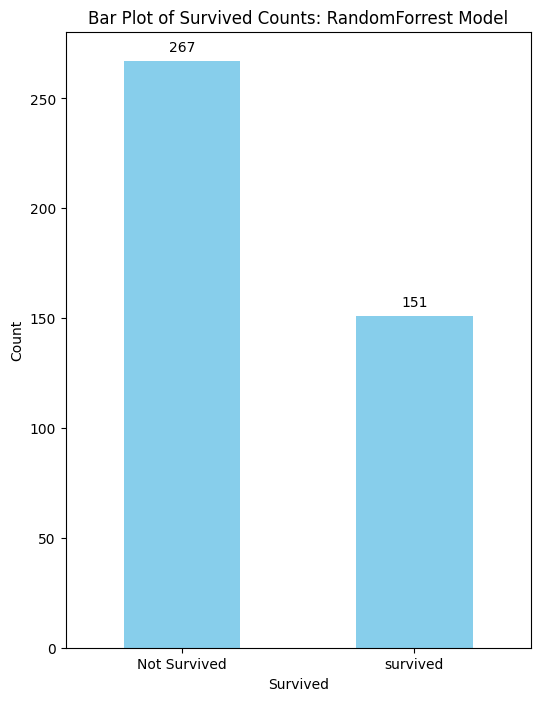

In [36]:
import matplotlib.pyplot as plt


# Count the occurrences of each category
category_counts = result_table['Survived'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 8))

ax=category_counts.plot(kind='bar', color='skyblue')

# Change category names on the x-axis
category_names = ['Not Survived', 'survived']
ax.set_xticklabels(category_names, rotation=0)

# Annotate each bar with its height
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels and title
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Bar Plot of Survived Counts: RandomForrest Model')

# Show the plot
plt.show()
